In [1]:
#pip install tensorflow

In [2]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_path="/kaggle/input/waste-classification-data/DATASET/TRAIN"
test_path="/kaggle/input/waste-classification-data/DATASET/TEST"


In [4]:
    #importing libraries
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, BatchNormalization
    from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
    from tensorflow.keras.utils import plot_model
    from glob import glob

In [5]:
#visualization
x_data=[]
y_data=[]
for category in  glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array=cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split('/')[-1])
data=pd.DataFrame({'image':x_data,'label':y_data})

100%|██████████| 12565/12565 [01:26<00:00, 144.90it/s]


In [6]:
data.shape

(22564, 2)

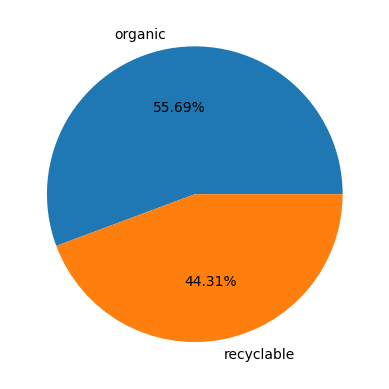

In [7]:
colors=['#a0d157' , '#c48bb8']
plt.pie(data.label.value_counts(),labels=['organic','recyclable'],autopct='%0.2f%%')
plt.show()

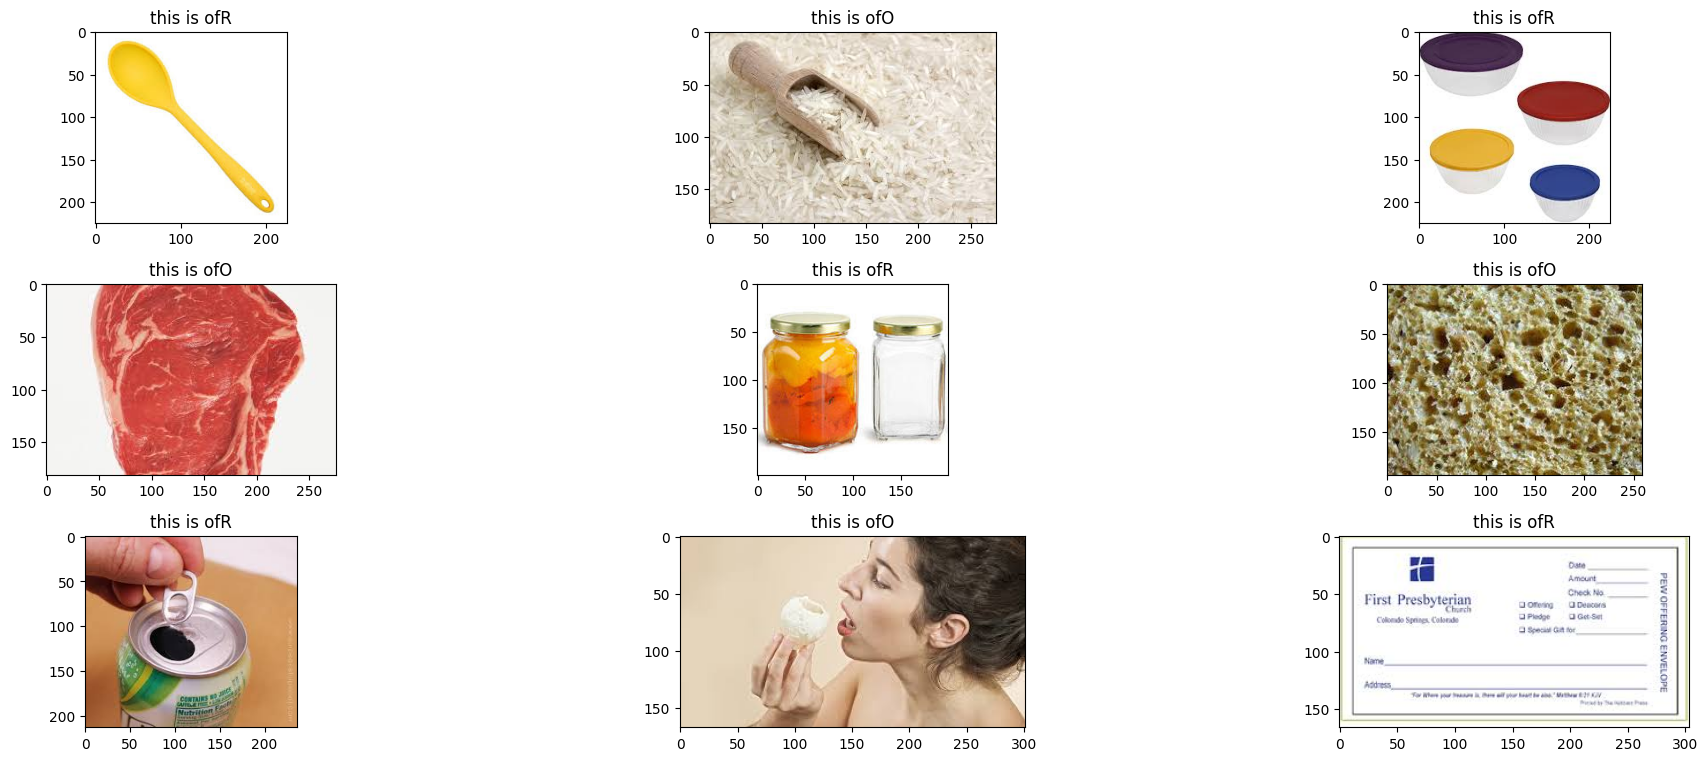

In [8]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(4,3,(i%10)+1)
    index = np.random.randint(15000)
    plt.title('this is of{0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

# Data Augmentation to improve generalization

#### Data augmentation helps the model generalize better by applying transformations
#### such as rotation, zoom, and flipping to artificially increase dataset size.
#### We use `ImageDataGenerator` with:
#### - `rescale`: Normalize pixel values to [0,1]
#### - `rotation_range`: Randomly rotate images
#### - `width_shift_range` & `height_shift_range`: Shift images horizontally/vertically
#### - `shear_range` & `zoom_range`: Apply shear and zoom effects
#### - `horizontal_flip`: Flip images horizontally
#### - `fill_mode`: Fill missing pixels with nearest values
#### - `validation_split`: Split data into training and validation sets (80/20)



In [9]:
# Data Augmentation for better generalization
"""
We use `ImageDataGenerator` to apply transformations such as:
- Rotation, width/height shift, shear, zoom, and flipping
- Rescaling pixel values to [0,1]
- Splitting training data into training (80%) and validation (20%)
"""
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# CNN MODEl
 

In [10]:
# Load training and validation data
"""
Generate training and validation datasets using augmentation.
Target size: 150x150 pixels, batch size: 32, class mode: categorical.
"""
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [11]:
def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

In [13]:
# Compile the CNN model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,814,402 (25.99 MB)

 Trainable params: 6,813,442 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [15]:
# Implement early stopping and checkpointing

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)  # Updated file format
]

In [16]:
# Train the CNN model

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.7545 - loss: 0.8517 - val_accuracy: 0.7739 - val_loss: 0.6305
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 128s 224ms/step - accuracy: 0.7912 - loss: 0.5940 - val_accuracy: 0.8149 - val_loss: 0.4956
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 128s 223ms/step - accuracy: 0.8199 - loss: 0.4879 - val_accuracy: 0.8143 - val_loss: 0.4529
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 132s 231ms/step - accuracy: 0.8321 - loss: 0.4360 - val_accuracy: 0.8105 - val_loss: 0.4685
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 129s 225ms/step - accuracy: 0.8363 - loss: 0.4242 - val_accuracy: 0.8367 - val_loss: 0.3974
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 128s 225ms/step - accuracy: 0.8317 - loss: 0.4092 - val_accuracy: 0.8327 - val_loss: 0.4124
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 128s 225ms/step - accuracy: 0.8439 - loss: 0.3886 - val_accuracy: 0.8502 - val_loss: 0.3782
Epoch 8/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 128s 225ms/step - accuracy: 0.8538 -

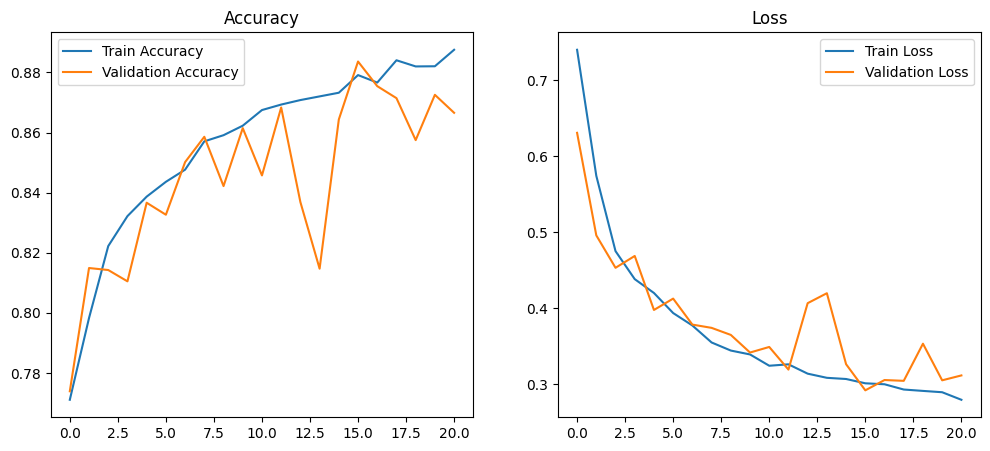

In [17]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [19]:
# Prepare Test Data

test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)


Found 2513 images belonging to 2 classes.


In [20]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.8884 - loss: 0.3258
Test Accuracy: 87.86%
Test Loss: 0.3272


In [21]:
# Make Predictions on Test Images

import numpy as np

# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


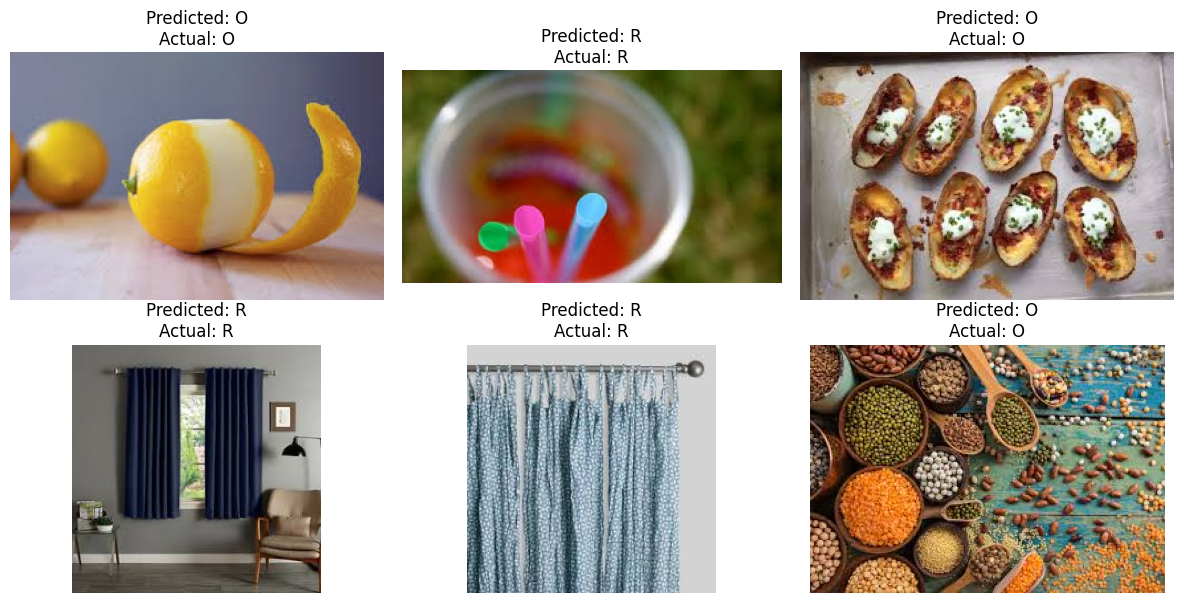

In [22]:
"""
# Visualize Some Test Images with Predictions
We randomly select some test images and display them with predicted labels.
"""
import matplotlib.pyplot as plt

# Get file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()


Classification Report:

              precision    recall  f1-score   support

           O       0.91      0.87      0.89      1401
           R       0.84      0.89      0.87      1112

    accuracy                           0.88      2513
   macro avg       0.88      0.88      0.88      2513
weighted avg       0.88      0.88      0.88      2513



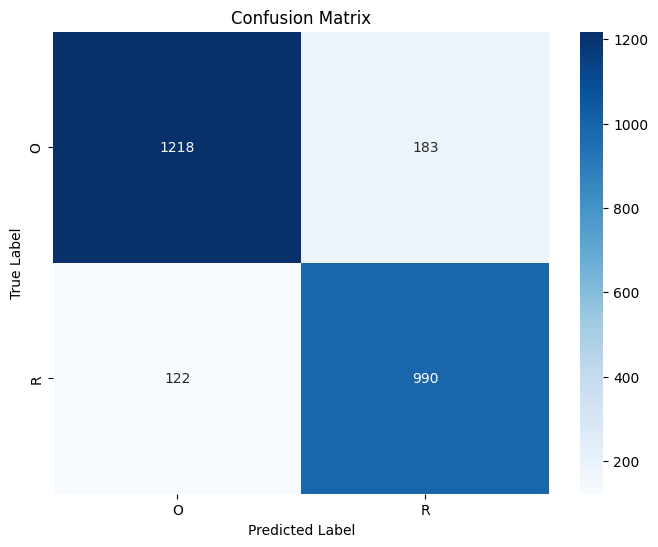

In [23]:
# Generate Classification Report and Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix
import seaborn as sns

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
